### Adding Emotion and Mouth position columns to the dataframe

In [149]:
import pandas as pd

df = pd.read_csv('RADIATE_Color_Faces_AU.csv', index_col=0)

df["emotion"] = df.index
df["emotion"] = df["emotion"].str.extract(r'.*_(.*).bmp')
# extract (.)(.) from the emotion column
temp = df["emotion"].str.extract(r'(.)(.)')

df["emotion"] = temp[0]
df["mouth"] = temp[1]

# if emotion is A, then replace A with angry
df["emotion"] = df["emotion"].replace("A", "angry")
# if emotion is C, then replace H with calm
df["emotion"] = df["emotion"].replace("C", "calm")
# if emotion is D, then replace D with disgust
df["emotion"] = df["emotion"].replace("D", "disgust")
# if emotion is F, then replace F with fear
df["emotion"] = df["emotion"].replace("F", "fear")
# if emotion is H, then replace H with happy
df["emotion"] = df["emotion"].replace("H", "happy")
# if emotion is N, then replace N with neutral
df["emotion"] = df["emotion"].replace("N", "neutral")

# if emotion is S, and mouth is U in the same row, then replace S with surprise
df.loc[(df["emotion"] == "S") & (df["mouth"] == "U"), "emotion"] = "surprise"
# if emotion is S, and mouth is not U in the same row, then replace S with sad
df.loc[(df["emotion"] == "S") & (df["mouth"] != "U"), "emotion"] = "sad"

# if mouth is O, then replace O with open
df["mouth"] = df["mouth"].replace("O", "open")
# if mouth is C, then replace C with closed
df["mouth"] = df["mouth"].replace("C", "closed")
# if mouth is U, then replace U with N/A
df["mouth"] = df["mouth"].replace("U", "N/A")
# if mouth is E, then replace E with exuberant
df["mouth"] = df["mouth"].replace("E", "exuberant")

# create an emotionID column
df["emotionID"] = df["emotion"].astype('category').cat.codes

# create a mouthID column
df["mouthID"] = df["mouth"].astype('category').cat.codes

# put the emotion and emotionID columns and mouth and mouthID columns at the beginning of the dataframe
df = df[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

# print first 15 rows
print(df.head(15))

               emotion  emotionID      mouth  mouthID      AU01      AU02  \
AF01_AC.bmp      angry          0     closed        1  0.495898  0.146762   
AF01_AO.bmp      angry          0       open        3  0.282826  0.065132   
AF01_CC.bmp       calm          1     closed        1  0.404276  0.129260   
AF01_CO.bmp       calm          1       open        3  0.430970  0.289695   
AF01_DC.bmp    disgust          2     closed        1  0.290751  0.143386   
AF01_DO.bmp    disgust          2       open        3  0.432929  0.075790   
AF01_FC.bmp       fear          3     closed        1  0.713720  0.474423   
AF01_FO.bmp       fear          3       open        3  0.634923  0.563915   
AF01_HC.bmp      happy          4     closed        1  0.566416  0.156642   
AF01_HE.bmp      happy          4  exuberant        2  0.380238  0.290982   
AF01_HO.bmp      happy          4       open        3  0.251061  0.258449   
AF01_NC.bmp    neutral          5     closed        1  0.296070  0.181766   

### Missing Values

In [150]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
emotion      0
emotionID    0
mouth        0
mouthID      0
AU01         0
AU02         0
AU04         0
AU05         0
AU06         0
AU07         0
AU09         0
AU10         0
AU11         0
AU12         0
AU14         0
AU15         0
AU17         0
AU20         0
AU23         0
AU24         0
AU25         0
AU26         0
AU28         0
AU43         0
dtype: int64


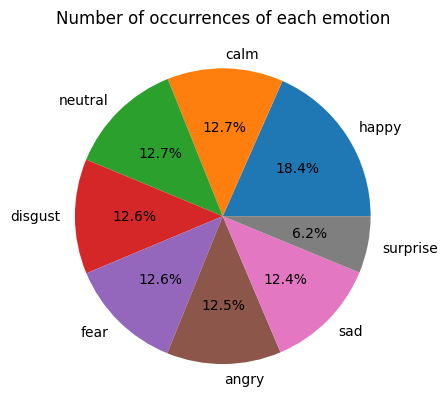

In [151]:
# count the number of occurrences of each emotion in the dataset
emotion_counts = df["emotion"].value_counts()

# plot a pie chart of the number of occurrences of each emotion in the dataset
import matplotlib.pyplot as plt
emotion_counts.plot.pie(autopct="%.1f%%")
plt.title("Number of occurrences of each emotion")
plt.ylabel("")
plt.show()

### Classifier

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# train test split
X = df.drop(columns=["emotion", "emotionID", "mouth"])
y = df["emotionID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

RandomForestClassifier Accuracy: 0.6656976744186046


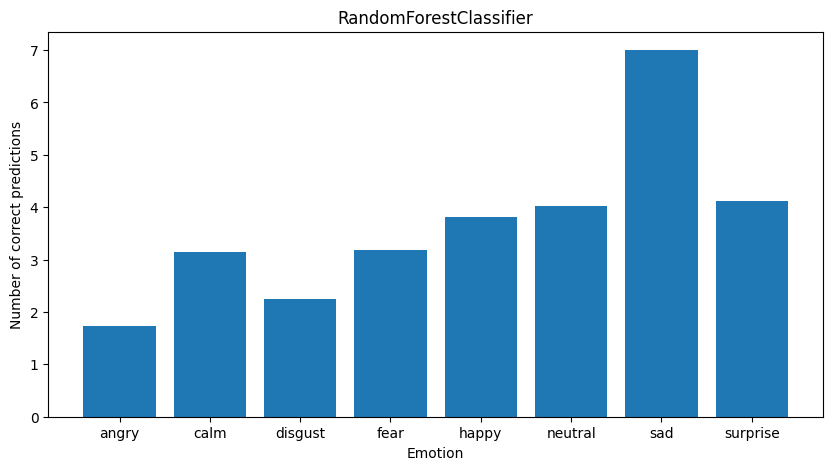

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# find the best classifier for the dataset, set the random_state to 42
classifiers = [
    RandomForestClassifier(random_state=42),
    # SVC(random_state=42),
    # DecisionTreeClassifier(random_state=42),
    # XGBClassifier(random_state=42)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "Accuracy:", accuracy_score(y_test, y_pred))

    # plot the number of correct predictions for each emotion for each classifier make it a percentage

    happy_predicted = y_pred[y_test == 4].sum() / (y_test == 4).sum()
    neutral_predicted = y_pred[y_test == 5].sum() / (y_test == 5).sum()
    surprise_predicted = y_pred[y_test == 6].sum() / (y_test == 6).sum()
    disgust_predicted = y_pred[y_test == 2].sum() / (y_test == 2).sum()
    sad_predicted = y_pred[y_test == 7].sum() / (y_test == 7).sum()
    fear_predicted = y_pred[y_test == 3].sum() / (y_test == 3).sum()
    angry_predicted = y_pred[y_test == 0].sum() / (y_test == 0).sum()
    calm_predicted = y_pred[y_test == 1].sum() / (y_test == 1).sum()

    # plot how many times each emotion was predicted correctly for each emotion
    plt.figure(figsize=(10, 5))
    plt.bar(["angry", "calm", "disgust", "fear", "happy", "neutral", "sad", "surprise"],
            [angry_predicted, calm_predicted, disgust_predicted, fear_predicted, happy_predicted, neutral_predicted,
             sad_predicted, surprise_predicted])
    plt.title(clf.__class__.__name__)
    plt.xlabel("Emotion")
    plt.ylabel("Number of correct predictions")
    plt.show()

### Feature Importance

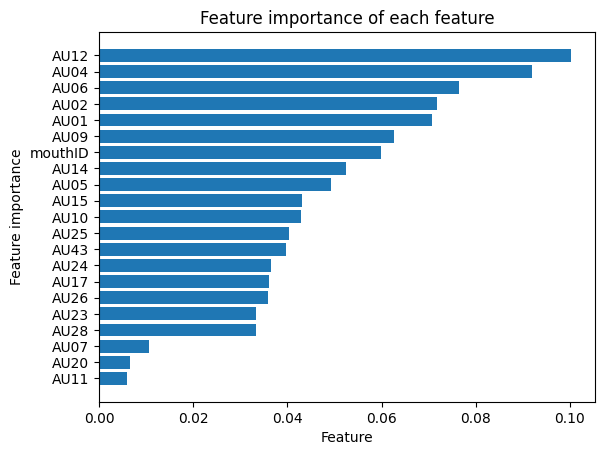

In [154]:
import matplotlib.pyplot as plt

# feature importance
feature_importance = clf.feature_importances_

# plot feature importance
sorted_idx = feature_importance.argsort()
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.title("Feature importance of each feature")
plt.show()